In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras import activations
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

import random
from math import floor
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scipy.integrate import odeint

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from scipy.stats import bernoulli

# import deap
from deap import base, creator, tools, algorithms

from bitstring import BitArray

# from elitism import eaSimpleWithElitism, main

2022-12-20 11:35:01.293276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 11:35:01.435928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 11:35:01.435955: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-20 11:35:02.494118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
np.random.seed(0)

# tf.config.optimizer.set_jit(True)
# scaler = StandardScaler()

In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/igomezv/nnogada/main/data/jla.csv'
df=pd.read_csv(url)

In [4]:
N = len(df.values)
randomize = np.random.permutation(N)
data = df.values[randomize]

In [5]:
N = len(df.values)
z = data[:,0] 
y = data[:,1:3] ### coge el resto de variables a predecir 
y[:,1] = y[:,1]**2+data[:,2]
np.shape(y)

(740, 2)

In [6]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
z = scalerz.transform(z.reshape(-1,1))

In [7]:
### Modificar para incluir phanteon como test
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
X_train, X_val = np.split(z, indx)
Y_train, Y_val = np.split(y, indx)
# X_train, X_test = np.split(z, indx)
# Y_train, Y_test = np.split(y, indx)
np.shape(X_train), np.shape(X_val), Y_train.shape, Y_val.shape

((592, 1), (148, 1), (592, 2), (148, 2))

In [8]:
SC_DEEP       = np.array([1,2,3,4])                           # Number of deep layers (8)
SC_NUM_UNITS  = np.array([50,100,150,200]) # Number of fully conected neurons (16)
SC_LEARNING   = np.array([1e-4,1e-3])   # Learning rates (8)
SC_BATCH      = np.array([2, 4, 8, 16])                            # Batch sizes (4)
# SC_ACTIVATION = [f1, f2, f3, f4]                                      # Activation function layers (2)

my_callbacks = [tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss', mode='min',
                               min_delta=0, 
                               patience=200,
                               verbose=1,
                            #    baseline=0,
                               restore_best_weights=True)
#                 keras.callbacks.TensorBoard(
#                                log_dir='./logs'),
#                 keras.callbacks.ReduceLROnPlateau(
#                                monitor='val_loss', factor=0.5,
#                                patience=6, min_lr=0,
#                                verbose=1)
               ] 
    
epochs = 200
# epochs = 3

In [9]:
def train_evaluate(ga_individual_solution):   
    t = time.time()
    t_total = 0
    
    # Decode GA solution to integer for window_size and num_units
    deep_layers_bits   = BitArray(ga_individual_solution[0:2])     # (8)
    num_units_bits     = BitArray(ga_individual_solution[2:4])     # (16)
    learning_rate_bits = BitArray(ga_individual_solution[4:5])    # (8)
    batch_size_bits    = BitArray(ga_individual_solution[5:7])   # (4)
# #     activation_f_bits  = BitArray(ga_individual_solution[12:13])   # (2)   Solo se consideran las 2 primeras
    
    deep_layers   = SC_DEEP[deep_layers_bits.uint]
    num_units     = SC_NUM_UNITS[num_units_bits.uint]
    learning_rate = SC_LEARNING[learning_rate_bits.uint]
    batch_size   = SC_BATCH[batch_size_bits.uint]
#     activation_f  = SC_ACTIVATION[activation_f_bits.uint]

    
    print('\n--------------- Starting trial:', population_size*(max_generations+1)-len(ss), "---------------")
    print('Deep layers:',deep_layers,', Number of neurons:',num_units,", Learning rate:",learning_rate)
#     print("-------------------------------------------------")
    
    # Train model and predict on validation set
    model = tf.keras.Sequential()
#     model.add(Input(shape=(int(X_train.shape[1]),)))
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(deep_layers):        
        model.add(Dense(num_units, activation='relu'))
#             model.add(keras.layers.Dropout(0.3))
    model.add(Dense(2, activation='linear'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
              callbacks=my_callbacks, batch_size=batch_size, shuffle=False, verbose=0)
    
    loss, score = model.evaluate(X_val, Y_val)    
    t = time.time()-t
    ss.pop(0)
    print("Loss:", score, ", Elapsed time:", t)
    print("-------------------------------------------------\n")
#     print(loss, score)

    datos.append([deep_layers, num_units, learning_rate, batch_size, loss, score, t])
    
    return loss,

In [10]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [11]:
def geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k):
    
    # Genetic Algorithm constants:
    P_CROSSOVER = 0.5        # probability for crossover
    P_MUTATION = 0.2         # probability for mutating an individual
    HALL_OF_FAME_SIZE = 1    # Best individuals that pass to the other generation
    
    # set the random seed:
    toolbox = base.Toolbox()

    # As we are trying to minimize the RMSE score, that's why using -1.0. 
    # In case, when you want to maximize accuracy for instance, use 1.0
    creator.create('FitnessMin', base.Fitness, weights = [-1.0])
    creator.create('Individual', list , fitness = creator.FitnessMin)

    # create the individual operator to fill up an Individual instance:
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)

    # create the population operator to generate a list of individuals:
    toolbox.register('population', tools.initRepeat, list , toolbox.individual)

    # genetic operators:
    toolbox.register('evaluate', train_evaluate)
    toolbox.register('select', tools.selTournament, tournsize = 2)
    toolbox.register('mutate', tools.mutFlipBit, indpb = 0.11)
    toolbox.register('mate', tools.cxUniform, indpb = 0.5)
    
    # create initial population (generation 0):
    population = toolbox.population(n=population_size)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # Genetic Algorithm flow with elitism:
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=max_generations, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    # extract statistics:
    minFitnessValues, meanFitnessValues, maxFitnessValues = logbook.select("min", "max", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='blue', label="Min")
    plt.plot(meanFitnessValues, color='green', label="Mean")
    plt.plot(maxFitnessValues, color='red', label="Max")
    plt.xlabel('Generation'); plt.ylabel('Max / Min / Average Fitness')
    plt.legend()
    plt.title('Max, Min and Average fitness over Generations')
    plt.show()
    
    best_population = tools.selBest(population,k = k)
    return best_population


--------------- Starting trial: 1 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.001


2022-12-20 11:35:03.697721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 11:35:03.697998: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 11:35:03.698084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-20 11:35:03.698160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-20 11:35:03.698237: W tensorflow/c

5/5 [==============================] - 0s 3ms/step - loss: 0.0759 - mean_squared_error: 0.0759
Loss: 0.07586070895195007 , Elapsed time: 141.3629240989685
-------------------------------------------------


--------------- Starting trial: 2 ---------------
Deep layers: 2 , Number of neurons: 200 , Learning rate: 0.0001
5/5 [==============================] - 0s 3ms/step - loss: 0.0481 - mean_squared_error: 0.0481
Loss: 0.0481216199696064 , Elapsed time: 26.529082536697388
-------------------------------------------------


--------------- Starting trial: 3 ---------------
Deep layers: 4 , Number of neurons: 200 , Learning rate: 0.001
5/5 [==============================] - 0s 5ms/step - loss: 0.0769 - mean_squared_error: 0.0769
Loss: 0.07693468034267426 , Elapsed time: 44.931854486465454
-------------------------------------------------


--------------- Starting trial: 4 ---------------
Deep layers: 1 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [==============================] 

5/5 [==============================] - 0s 3ms/step - loss: 0.0672 - mean_squared_error: 0.0672
Loss: 0.06721914559602737 , Elapsed time: 29.075115203857422
-------------------------------------------------


--------------- Starting trial: 27 ---------------
Deep layers: 2 , Number of neurons: 200 , Learning rate: 0.001
5/5 [==============================] - 0s 3ms/step - loss: 0.0511 - mean_squared_error: 0.0511
Loss: 0.05112677067518234 , Elapsed time: 80.07725930213928
-------------------------------------------------


--------------- Starting trial: 28 ---------------
Deep layers: 1 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [==============================] - 0s 3ms/step - loss: 0.0711 - mean_squared_error: 0.0711
Loss: 0.07105650007724762 , Elapsed time: 66.00787305831909
-------------------------------------------------


--------------- Starting trial: 29 ---------------
Deep layers: 2 , Number of neurons: 200 , Learning rate: 0.001
5/5 [==============================

5/5 [==============================] - 0s 3ms/step - loss: 0.0301 - mean_squared_error: 0.0301
Loss: 0.030144598335027695 , Elapsed time: 77.58081603050232
-------------------------------------------------


--------------- Starting trial: 52 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [==============================] - 0s 3ms/step - loss: 0.0304 - mean_squared_error: 0.0304
Loss: 0.030384624376893044 , Elapsed time: 79.00771737098694
-------------------------------------------------


--------------- Starting trial: 53 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [==============================] - 0s 2ms/step - loss: 0.0306 - mean_squared_error: 0.0306
Loss: 0.030607612803578377 , Elapsed time: 73.9221568107605
-------------------------------------------------


--------------- Starting trial: 54 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [===========================

5/5 [==============================] - 0s 2ms/step - loss: 0.0643 - mean_squared_error: 0.0643
Loss: 0.06425879895687103 , Elapsed time: 67.93919467926025
-------------------------------------------------


--------------- Starting trial: 77 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.001
5/5 [==============================] - 0s 2ms/step - loss: 0.0461 - mean_squared_error: 0.0461
Loss: 0.0460967943072319 , Elapsed time: 73.99325203895569
-------------------------------------------------


--------------- Starting trial: 78 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [==============================] - 0s 2ms/step - loss: 0.0313 - mean_squared_error: 0.0313
Loss: 0.03132178634405136 , Elapsed time: 78.07695484161377
-------------------------------------------------

7  	11    	0.0301446	0.0663531	0.505595 

--------------- Starting trial: 79 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.

5/5 [==============================] - 0s 2ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Loss: 0.03151467815041542 , Elapsed time: 57.84071063995361
-------------------------------------------------


--------------- Starting trial: 102 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [==============================] - 0s 3ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Loss: 0.03183915093541145 , Elapsed time: 65.71128273010254
-------------------------------------------------


--------------- Starting trial: 103 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [==============================] - 0s 2ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Loss: 0.03284566476941109 , Elapsed time: 83.7557442188263
-------------------------------------------------


--------------- Starting trial: 104 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
5/5 [===========================

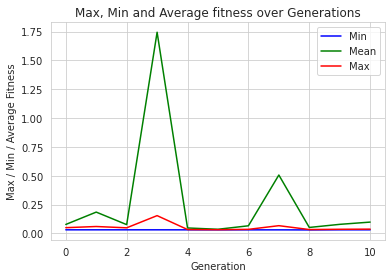

Total elapsed time: 126.2018733382225 minutes


In [12]:
population_size = 15  # max of individuals per generation
max_generations = 10  # number of generations
gene_length = 7      # lenght of the gene, depends on how many hiperparameters are tested  
k = 1;                 # num. of finalist individuals

if __name__ == "__main__":
    t = time.time(); 
    datos = [];
    ss = [i for i in range(1,population_size*(max_generations+1))]
    best_population = geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k)
    print("Total elapsed time:", (time.time()-t)/60, "minutes")

In [13]:
best_deep_layers   = []
best_num_units     = []
best_learning_rate = []
best_batch_size    = []
# best_activation_f  = []
best_f_names       = []

t = 0

for bi in best_population:
    deep_layers_bits   = BitArray(bi[0:1])    # (8)
    num_units_bits     = BitArray(bi[1:2])    # (16)
    learning_rate_bits = BitArray(bi[2:3])   # (8)
    batch_size_bits    = BitArray(bi[3:4])  # (4)
#     activation_f_bits  = BitArray(bi[12:13])  # (2)
    t += 1 
    
    best_deep_layers.append(SC_DEEP[deep_layers_bits.uint])
    best_num_units.append(SC_NUM_UNITS[num_units_bits.uint])
    best_learning_rate.append(SC_LEARNING[learning_rate_bits.uint])
    best_batch_size.append(SC_BATCH[batch_size_bits.uint])
#     best_activation_f.append(SC_ACTIVATION[activation_f_bits.uint])
#     best_f_names.append(f_names[activation_f_bits.uint])
    print('k=',t,'\nDeep layers:', best_deep_layers[-1], ', Number of neurons:', best_num_units[-1])
    print('Batch size', best_batch_size[-1], ', Learning rate:', best_learning_rate[-1])

k= 1 
Deep layers: 2 , Number of neurons: 50
Batch size 4 , Learning rate: 0.0001


In [14]:
filename = "historial_genetic_jla2.txt"
df = pd.DataFrame(datos, columns = ["Deep layers", "Num units", "Learning rate", "Batch size", "Loss", "Score", "Elapsed time"])

df.sort_values(by=["Loss", "Elapsed time"], ascending=[True, True], ignore_index=True, inplace=True)

df.to_csv(filename, header=True, index=False, sep='\t', mode='w') # a=append, w=overwrite
df.head(50)

,Deep layers,Num units,Learning rate,Batch size,Loss,Score,Elapsed time
0,3,100,0.0001,4,0.029587,0.029587,83.957397
1,3,100,0.0001,4,0.030145,0.030145,77.580816
2,3,100,0.0001,4,0.030298,0.030298,80.241825
3,3,100,0.0001,4,0.030385,0.030385,79.007717
4,3,100,0.0001,4,0.030394,0.030394,68.293768
5,3,100,0.0001,4,0.030404,0.030404,53.452576
6,3,100,0.0001,4,0.030450,0.030450,69.964900
7,3,100,0.0001,4,0.030506,0.030506,83.982106
8,3,100,0.0001,4,0.030608,0.030608,73.922157
9,3,100,0.0001,4,0.030617,0.030617,51.408198


In [15]:
total_time = float(np.sum(df[["Elapsed time"]])/60)

print("Elapsed time {:.3f} minutes".format(total_time))

Elapsed time 126.196 minutes
